In [9]:
# Cell 1: Import Libraries and Load the Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

print("Dataset columns: ", dataset['train'].column_names)
print("Sample data: ")
print(dataset['train'][0])

# Convert dataset to DataFrame
df = pd.DataFrame(dataset['train'])
print("First 5 entries in the dataset:")
print(df.head())

# Split into train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

print("First 5 rows of the training set:")
print(train.head())
print("\nFirst 5 rows of the test set:")
print(test.head())


Dataset columns:  ['sentence', 'label']
Sample data: 
{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'label': 1}
First 5 entries in the dataset:
                                            sentence  label
0  According to Gran , the company has no plans t...      1
1  For the last quarter of 2010 , Componenta 's n...      2
2  In the third quarter of 2010 , net sales incre...      2
3  Operating profit rose to EUR 13.1 mn from EUR ...      2
4  Operating profit totalled EUR 21.1 mn , up fro...      2
First 5 rows of the training set:
                                               sentence  label
316   The robust growth was the result of the inclus...      2
2161  Operating profit fell to EUR 23.26 mn from EUR...      0
1894  Finnish electronics manufacturing services EMS...      0
427   Finland 's national carrier Finnair PLC carrie...      2
374   The Elcoteq group recently announced that t

## Data Preprocessing (Tokenization, Padding, Label Encoding)

In [10]:
# Cell 2: Data Preprocessing (Tokenization, Padding, Label Encoding)
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Combine texts for fitting the tokenizer
all_texts = pd.concat([train['sentence'], test['sentence']])

# Initialize the tokenizer
max_vocab_size = 10000  # You can adjust this value
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(all_texts)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train['sentence'])
X_test_seq = tokenizer.texts_to_sequences(test['sentence'])

# Determine maximum sequence length (you can also set a fixed value)
max_seq_length = max(len(seq) for seq in X_train_seq)
print(f"Maximum sequence length: {max_seq_length}")

# Pad sequences to the same length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post', truncating='post')

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(train['label'])

y_train = label_encoder.transform(train['label'])
y_test = label_encoder.transform(test['label'])

# Convert labels to one-hot vectors
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Split training data into training and validation sets
from sklearn.model_selection import train_test_split

X_train_padded, X_val_padded, y_train_cat, y_val_cat = train_test_split(
    X_train_padded, y_train_cat, test_size=0.1, random_state=42)


Maximum sequence length: 53


## Define Function to Train and Evaluate Models

In [11]:
# Cell 3: Define Function to Train and Evaluate Models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_model(model, model_name):
    print(f"\nTraining {model_name}...\n")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(
        X_train_padded, y_train_cat,
        validation_data=(X_val_padded, y_val_cat),
        epochs=5,
        batch_size=64,
        verbose=1
    )
    
    # Evaluate on test data
    y_pred_prob = model.predict(X_test_padded)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Convert label names to strings
    target_names = [str(cls) for cls in label_encoder.classes_]
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return {'model': model_name, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1, 'history': history}


### RNN


Training RNN...

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6087 - loss: 0.9403 - val_accuracy: 0.7088 - val_loss: 0.7038
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7664 - loss: 0.6060 - val_accuracy: 0.6868 - val_loss: 0.8107
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7996 - loss: 0.5148 - val_accuracy: 0.7308 - val_loss: 0.7142
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8258 - loss: 0.4083 - val_accuracy: 0.7253 - val_loss: 0.7428
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8307 - loss: 0.3947 - val_accuracy: 0.7363 - val_loss: 0.6989
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RNN Performance:
Accuracy: 0.7660
Precision: 0.7012
Recall: 0.7660
F1 Score: 0.7267

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.91      0.90      0.90       276
           2       0.55      0.82      0.

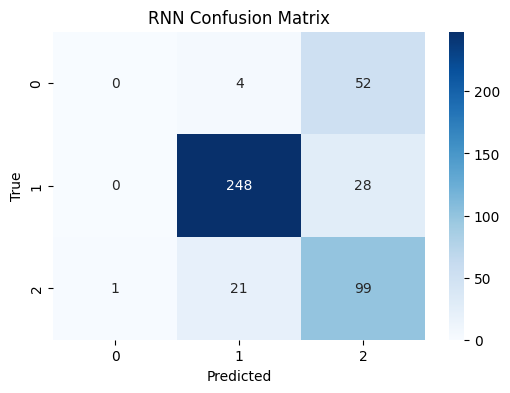

In [12]:
# Cell 4: RNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

embedding_dim = 128  # You can adjust this value

rnn_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=64),
    Dense(num_classes, activation='softmax')
])

# Train and evaluate the RNN model
rnn_performance = train_and_evaluate_model(rnn_model, 'RNN')


## LSTM


Training LSTM...

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.6024 - loss: 0.9759 - val_accuracy: 0.6703 - val_loss: 0.8572
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6207 - loss: 0.9129 - val_accuracy: 0.6703 - val_loss: 0.8390
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6384 - loss: 0.8614 - val_accuracy: 0.7582 - val_loss: 0.6410
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7696 - loss: 0.5938 - val_accuracy: 0.7692 - val_loss: 0.6231
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7687 - loss: 0.5786 - val_accuracy: 0.7418 - val_loss: 0.7750
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM Performance:
Accuracy: 0.7550
Precision: 0.6717
Recall: 0.7550
F1 Score: 0.7099

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.86      0.92      0.89       276
           2       0.56      0.73      

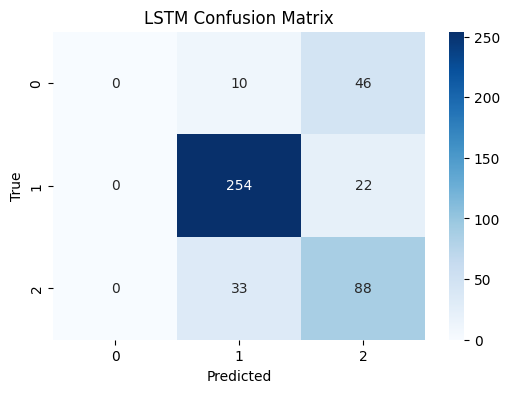

In [13]:
# Cell 5: LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

lstm_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim),
    LSTM(units=64),
    Dense(num_classes, activation='softmax')
])

# Train and evaluate the LSTM model
lstm_performance = train_and_evaluate_model(lstm_model, 'LSTM')


## Seq2Seq


Training Seq2Seq...

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.5482 - loss: 0.9904 - val_accuracy: 0.6703 - val_loss: 0.8684
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6193 - loss: 0.9196 - val_accuracy: 0.6703 - val_loss: 0.8614
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6387 - loss: 0.8932 - val_accuracy: 0.6703 - val_loss: 0.8784
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6635 - loss: 0.8322 - val_accuracy: 0.6758 - val_loss: 0.8989
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7659 - loss: 0.6573 - val_accuracy: 0.7308 - val_loss: 0.7649
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Seq2Seq Performance:
Accuracy: 0.7307
Precision: 0.6775
Recall: 0.7307
F1 Score: 0.6951

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.89      0.84      0.86       276
           2       0.52      0.81

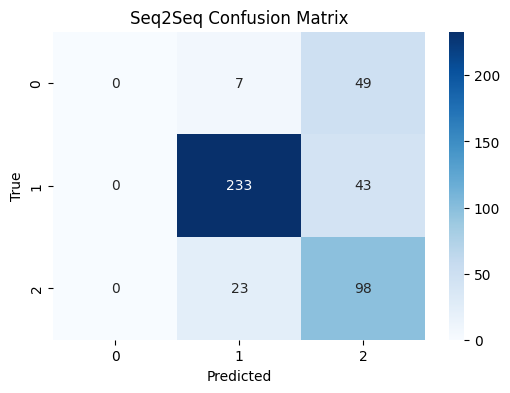

In [14]:
# Cell 6: Seq2Seq Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

def build_seq2seq_model():
    embedding_dim = 128
    latent_dim = 64

    # Encoder
    encoder_inputs = Input(shape=(max_seq_length,))
    x = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim)(encoder_inputs)
    encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(x)
    encoder_states = [state_h, state_c]

    # For classification, we use the encoder's final state
    outputs = Dense(num_classes, activation='softmax')(state_h)

    model = Model(encoder_inputs, outputs)
    return model

seq2seq_model = build_seq2seq_model()

# Train and evaluate the Seq2Seq model
seq2seq_performance = train_and_evaluate_model(seq2seq_model, 'Seq2Seq')


## Transformer Model


Training Transformer...

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.5482 - loss: 1.0617 - val_accuracy: 0.6923 - val_loss: 0.6960
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.6981 - loss: 0.6911 - val_accuracy: 0.7473 - val_loss: 0.6596
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7906 - loss: 0.5022 - val_accuracy: 0.7308 - val_loss: 0.6086
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8505 - loss: 0.3559 - val_accuracy: 0.8022 - val_loss: 0.4757
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9659 - loss: 0.1147 - val_accuracy: 0.8791 - val_loss: 0.4617
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Transformer Performance:
Accuracy: 0.8830
Precision: 0.8851
Recall: 0.8830
F1 Score: 0.8777

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.57      0.71        56
           1       0.90      0.97      0.94       276
           2       

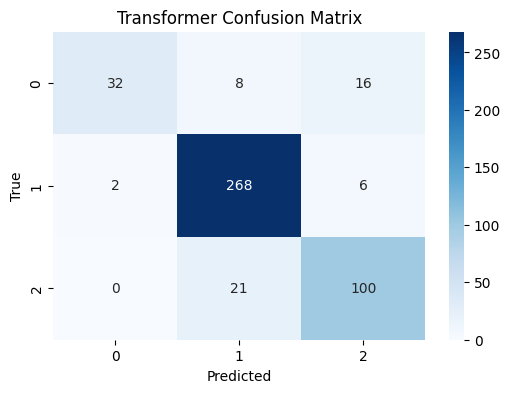

In [15]:
# Cell 7: Transformer Model
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def call(self, inputs, training=False):  # Set default training=False
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model():
    embed_dim = 128
    num_heads = 4
    ff_dim = 128

    inputs = Input(shape=(max_seq_length,))
    embedding_layer = Embedding(max_vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)  # No need to pass 'training' explicitly
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

transformer_model = build_transformer_model()

# Train and evaluate the Transformer model
transformer_performance = train_and_evaluate_model(transformer_model, 'Transformer')


## Comparing the models

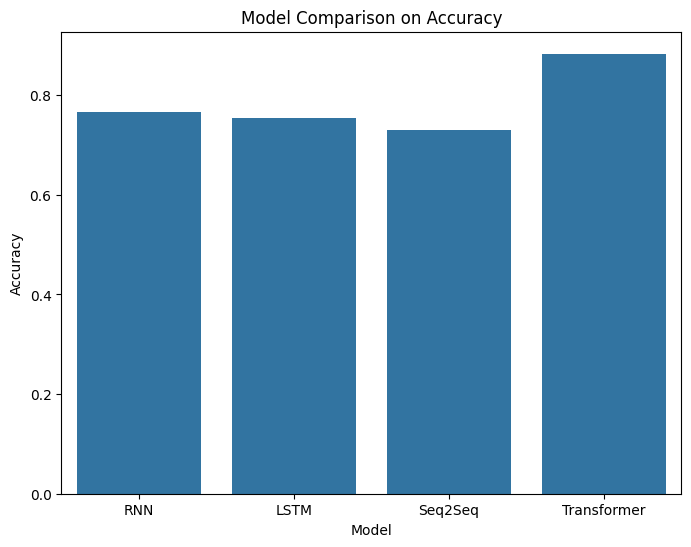

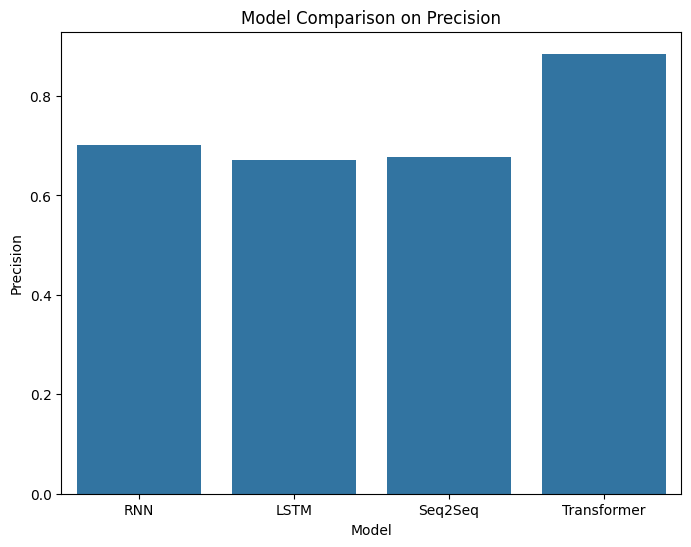

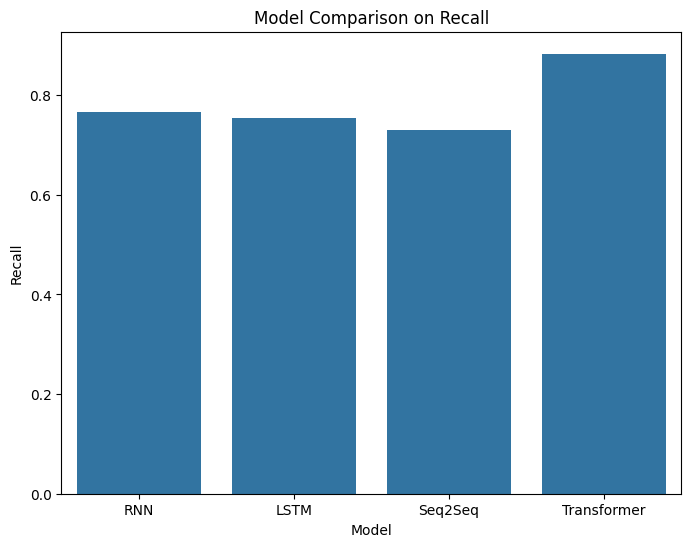

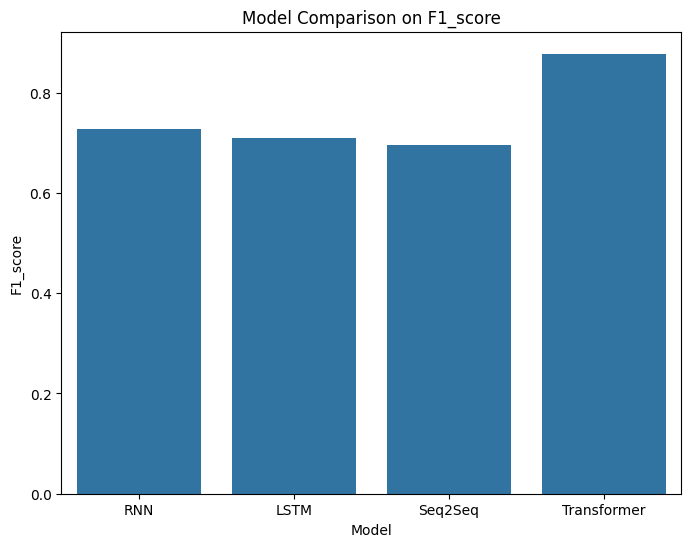


Overall Model Performance:
         model  accuracy  precision    recall  f1_score
0          RNN  0.766004   0.701208  0.766004  0.726744
1         LSTM  0.754967   0.671737  0.754967  0.709872
2      Seq2Seq  0.730684   0.677544  0.730684  0.695092
3  Transformer  0.883002   0.885070  0.883002  0.877679

The best model is Transformer with an F1 Score of 0.8777


In [16]:
# Cell 8: Compare Model Performances and Visualization
# Collect performances
model_performances = [
    rnn_performance,
    lstm_performance,
    seq2seq_performance,
    transformer_performance
]

# Create a DataFrame for comparison
performance_df = pd.DataFrame(model_performances)

# Plotting the metrics
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics:
    plt.figure(figsize=(8, 6))
    sns.barplot(x='model', y=metric, data=performance_df)
    plt.title(f'Model Comparison on {metric.capitalize()}')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Model')
    plt.show()

# Display overall comparison table
print("\nOverall Model Performance:")
print(performance_df[['model', 'accuracy', 'precision', 'recall', 'f1_score']])

# Determine which model worked the best based on F1 Score
best_model = performance_df.loc[performance_df['f1_score'].idxmax()]
print(f"\nThe best model is {best_model['model']} with an F1 Score of {best_model['f1_score']:.4f}")
